In [1]:
import principal_portfolios as pp
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from functools import reduce

In [2]:
def construct_monthly_return(df):
    df['date'] = pd.to_datetime(df['date'])

    # Step 2: Set 'Date' as the index to enable resampling
    df.set_index('date', inplace=True)

    # Step 3: Resample to get the last price of each month (monthly frequency 'M')
    monthly_prices = df.resample('M').last()

    # Step 4: Calculate the monthly returns for each column (except 'Date')
    monthly_returns = monthly_prices.pct_change() * 100

    # Step 5: Reset the index to have 'Date' as a column again
    monthly_returns.reset_index(inplace=True)
    monthly_returns.dropna(inplace=True)

    return monthly_returns

In [3]:
def exclude_redundant_columns(df):
    corr_matrix = df.iloc[:,1:].corr()
    to_drop = []

    # Iterate over the columns of the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > 0.98 or corr_matrix.iloc[i, j] < -0.98:
                colname = corr_matrix.columns[j]
                if colname not in to_drop:
                    to_drop.append(colname)

    # Now drop the identified columns from the dataframe, keeping only the first
    filtered_corr_matrix = corr_matrix.drop(columns=to_drop, index=to_drop)
    columns_to_keep = filtered_corr_matrix.columns.to_list()

    df = df[['date']+columns_to_keep]
    
    return df

### Reading MS data and Merging portfolio data into a dataframe.

In [4]:
data_to_read_address = "data/FX/Portfolio/MSFX.xlsx"
fx_ms_df = pd.read_excel(data_to_read_address)

dfs = []

# Loop through the dataframe, two columns at a time (one for date, one for value)
for i in range(0, len(fx_ms_df.columns), 2):
    date_col = fx_ms_df.columns[i]
    value_col = fx_ms_df.columns[i + 1]
    
    # Rename the columns for clarity
    instrument_name = date_col.replace(' Index', '')
    
    # Create a new dataframe for the current instrument
    temp_df = fx_ms_df[[date_col, value_col]].copy()
    temp_df.columns = ['date', instrument_name]
    
    # Remove rows where the date is NaT or NaN in both columns
    temp_df = temp_df.dropna(subset=['date', instrument_name])
    
    # Append the dataframe to the list
    dfs.append(temp_df)

# Perform an inner join on the 'date' column for all dataframes
merged_ms_prtf_df = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)

# Remove any remaining rows with NaT or NaN after merging
merged_ms_prtf_df.dropna(inplace=True)
merged_ms_prtf_df = construct_monthly_return(merged_ms_prtf_df)

### Reading DB data

In [5]:
data_to_read_address = "data/FX/Portfolio/DB_FX_PRTF_1.xlsx"
db_data_df_1= pd.read_excel(data_to_read_address)
db_data_df_1.dropna(inplace=True)
monthly_db_1_returns = construct_monthly_return(db_data_df_1)

In [6]:
data_to_read_address = "data/FX/Portfolio/DB_FX_PRTF_2.xlsx"
db_data_df_2= pd.read_excel(data_to_read_address)
db_data_df_2.dropna(inplace=True)
monthly_db_2_returns = construct_monthly_return(db_data_df_2)

In [7]:
data_to_read_address = "data/FX/Portfolio/DB_FX_PRTF_3.xlsx"
db_data_df_3= pd.read_excel(data_to_read_address)
db_data_df_3.dropna(inplace=True)
monthly_db_3_returns = construct_monthly_return(db_data_df_3)

In [8]:
data_to_read_address = "data/FX/Portfolio/DB_FX_PRTF_4.xlsx"
db_data_df_4= pd.read_excel(data_to_read_address)
db_data_df_4.dropna(inplace=True)
monthly_db_4_returns = construct_monthly_return(db_data_df_4)

In [9]:
dfs = [merged_ms_prtf_df, monthly_db_1_returns, monthly_db_2_returns, monthly_db_3_returns, monthly_db_4_returns]

# Perform inner join on 'id' column for all DataFrames
basket_portfolios = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)

## this part and the function I defined above are not well-defined.

In [10]:
basket_portfolios = exclude_redundant_columns(basket_portfolios)

In [11]:
basket_portfolios

,date,MSCEAUDL,MSCEGBPL,MSCECADL,MSCEEURL,MSCEJPYL,MSCENZDL,MSCENOKL,MSCESEKL,MSCECHFL,...,MSCECARU,MSCEQSIU,MSCERERU,MSCEPOSU,Deutsche Bank FX Valuation USD Index,Deutsche Bank CoreSeries FX Carry Balanced USD Index,Deutsche Bank CoreSeries FX Carry Global USD Index,Deutsche Bank FX Momentum USD Index,DB G10 Currency Future Harvest TR Index,Deutsche Bank Short USD Currency Portfolio Index-Total Return
0,2002-04-30,2.261741,2.673501,1.946734,3.516918,3.197433,3.167814,5.717075,1.281210,3.956787,...,6.465285,3.581284,0.251789,-3.798736,-2.856305,2.138505,1.198208,-0.105282,0.685445,3.269872
1,2002-05-31,5.774722,0.153977,2.799906,4.024000,3.472052,7.924353,6.130986,5.600189,3.277331,...,11.624013,-0.587826,3.645497,7.127353,1.248650,1.827165,-0.264381,3.373320,4.101956,3.027094
2,2002-06-30,-0.350301,5.644340,0.887939,6.398691,3.954615,1.815455,6.856646,6.719680,5.948699,...,9.238869,-0.556348,-6.494722,10.319751,-4.763009,-1.972973,-4.104920,3.342460,-0.000564,5.343327
3,2002-07-31,-3.269792,2.315450,-4.010919,-1.106440,-0.334643,-4.022706,-1.232849,-2.947405,-0.183359,...,-4.094007,-1.274165,-4.464629,-2.181352,-3.199150,-0.828584,0.047092,0.057761,-2.325719,-0.831208
4,2002-08-31,2.121482,-0.734721,1.840665,0.911231,1.313791,1.205338,2.292833,2.234135,-0.590323,...,1.648070,1.222371,1.278436,1.154865,0.680392,2.055886,1.982307,-1.222818,1.380444,0.664984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,2021-08-31,-0.580693,-1.015426,-1.199703,-0.502839,-0.118024,0.840719,1.477968,-0.419946,-1.135030,...,1.159625,-0.539140,0.717378,0.920022,-0.519411,0.996304,1.355685,-0.353066,1.231015,-0.498333
233,2021-09-30,-1.173452,-2.027793,-0.243338,-1.876842,-1.554024,-1.991199,-0.273971,-1.277719,-1.874076,...,4.726355,-1.043534,1.927623,2.590691,-0.117018,-0.634692,-1.692568,-0.675937,0.732560,-1.738730
234,2021-10-31,3.970678,1.659115,2.208131,-0.196370,-2.164148,3.770935,3.210533,1.845906,2.020671,...,-3.996640,0.388829,-2.077925,-3.630598,-3.077781,-0.977008,-2.412460,2.456797,3.335492,0.134899
235,2021-11-30,-5.603702,-3.482298,-3.362048,-2.782506,0.414521,-5.137153,-7.138163,-5.374156,-1.325493,...,10.338704,0.651213,-0.137276,5.327638,2.895012,-6.390116,-5.706928,-3.293615,-4.240511,-2.067530


## PP 

dict_keys(['fx_ms_portfolio_momentum_monthly'])
dict_keys(['realized_returns_df', 'sharpe_df', 'pp_realized_mean_df', 'pp_expected_mean_df', 'pep_realized_mean_df', 'pep_expected_mean_df', 'pap_realized_mean_df', 'pap_expected_mean_df'])
return_of_simple_factor          -0.336864
realized_return_of_first_n_PP     0.206450
realized_return_of_first_n_PEP    0.610963
realized_return_of_first_n_PAP    0.522741
realized_return_of_1_PP           0.360851
                                    ...   
realized_return_of_16_PAP        -0.052973
realized_return_of_17_PAP        -0.328805
realized_return_of_18_PAP         0.664214
realized_return_of_19_PAP        -0.395424
PEP and PAP 1-n                   0.800042
Length: 102, dtype: float64


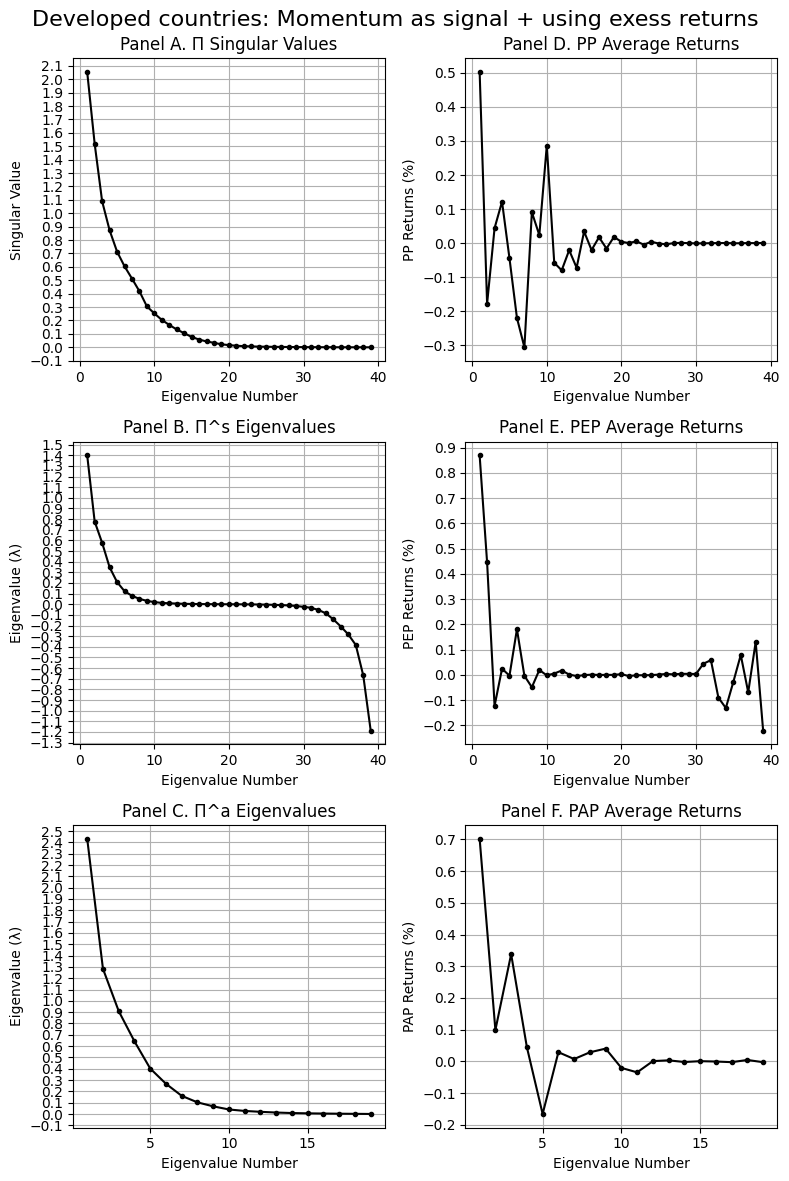

In [12]:
starting_year_to_filter = 1996
end_year_to_filter = 2024
number_of_lookback_periods = 90
number_of_PPs_to_consider = 3
number_of_PEPs_to_consider = 3
number_of_PAPs_to_consider = 3
output_dict_momentum = {}


basket_portfolios['date'] = pp.convert_date_column_for_monthly_data(basket_portfolios)
signal_df = pp.build_signal_df_for_1month_momentum(basket_portfolios)



portfolios_key = "fx_ms_portfolio_momentum_monthly"
output_dict_momentum[portfolios_key] = pp.build_PP(basket_portfolios,signal_df,
                                                                   number_of_lookback_periods,starting_year_to_filter,end_year_to_filter,
                                                                   factor_data_monthly=None, number_of_PPs_to_consider=number_of_PPs_to_consider,
                                                                   number_of_PEPs_to_consider=number_of_PEPs_to_consider, 
                                                                   number_of_PAPs_to_consider= number_of_PAPs_to_consider)

# I calculate the results for all datasets. the results are stored in this dictionay.
print(output_dict_momentum.keys())
'''
Every value of this dictionary is itself another dictionary.
For instance the key 'sharpe_df' can be used to access the sharp values of this set of results.
'''
print(output_dict_momentum[portfolios_key].keys())
print(output_dict_momentum[portfolios_key]["sharpe_df"])

number_of_portfolios = basket_portfolios.shape[1]
title = 'Developed countries: Momentum as signal + using exess returns'

pp.singular_values_vs_realized_returns_graph(output_dict_momentum, portfolios_key, number_of_portfolios, title)

In [13]:
output_dict_momentum[portfolios_key]["sharpe_df"].to_csv("test1.csv")

In [14]:
pp.calculate_sharpe_ratio(basket_portfolios.iloc[number_of_lookback_periods:,1:].mean(axis=1)) * math.sqrt(12)

0.18680717924101203

In [15]:
basket_portfolios.iloc[number_of_lookback_periods:,1:].apply(lambda col: pp.calculate_sharpe_ratio(col)) * math.sqrt(12)

MSCEAUDL                                                         0.088823
MSCEGBPL                                                        -0.121026
MSCECADL                                                        -0.070273
MSCEEURL                                                        -0.249353
MSCEJPYL                                                        -0.234332
MSCENZDL                                                         0.174085
MSCENOKL                                                        -0.178406
MSCESEKL                                                        -0.161090
MSCECHFL                                                         0.058712
MSCEEAL                                                          0.339079
MSCEEGL                                                          0.149488
MSCEECL                                                          0.209059
MSCEEJL                                                          0.041339
MSCEEZL                               